<a href="https://colab.research.google.com/github/Parth7/ML-for-finance/blob/main/Wavenet_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from google.colab import files
uploaded = files.upload()

Saving ^GSPC.csv to ^GSPC.csv
Saving ^IXIC.csv to ^IXIC.csv
Saving AAPL.csv to AAPL.csv
Saving MSFT.csv to MSFT.csv


In [3]:
import io
aapl_raw = pd.read_csv(io.StringIO(uploaded['AAPL.csv'].decode('utf-8')))
msft_raw = pd.read_csv(io.StringIO(uploaded['MSFT.csv'].decode('utf-8')))
nsdq_raw = pd.read_csv(io.StringIO(uploaded['^IXIC.csv'].decode('utf-8')))
sp500_raw = pd.read_csv(io.StringIO(uploaded['^GSPC.csv'].decode('utf-8')))

In [4]:
aapl_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4865 entries, 0 to 4864
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4865 non-null   object 
 1   Open       4865 non-null   float64
 2   High       4865 non-null   float64
 3   Low        4865 non-null   float64
 4   Close      4865 non-null   float64
 5   Adj Close  4865 non-null   float64
 6   Volume     4865 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 266.2+ KB


In [5]:
aapl_raw.index = pd.to_datetime(aapl_raw.Date).dt.date
msft_raw.index = pd.to_datetime(msft_raw.Date).dt.date
sp500_raw.index = pd.to_datetime(sp500_raw.Date).dt.date
nsdq_raw.index = pd.to_datetime(nsdq_raw.Date).dt.date

In [6]:
aapl_raw.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2000-01-03,2000-01-03,3.745536,4.017857,3.631696,3.997768,2.665724,133949200
2000-01-04,2000-01-04,3.866071,3.950893,3.613839,3.660714,2.440975,128094400
2000-01-05,2000-01-05,3.705357,3.948661,3.678571,3.714286,2.476697,194580400
2000-01-06,2000-01-06,3.790179,3.821429,3.392857,3.392857,2.262367,191993200
2000-01-07,2000-01-07,3.446429,3.607143,3.410714,3.553571,2.369532,115183600


In [7]:
aapl_raw['aAC'] = aapl_raw['Adj Close']
msft_raw['mAC'] = msft_raw['Adj Close']
sp500_raw['sAC'] = sp500_raw['Adj Close']
nsdq_raw['nAC'] = nsdq_raw['Adj Close']

In [8]:
aapl_raw['aV'] = aapl_raw['Volume']
msft_raw['mV'] = msft_raw['Volume']
sp500_raw['sV'] = sp500_raw['Volume']
nsdq_raw['nV'] = nsdq_raw['Volume']

In [9]:
aapl = aapl_raw.drop(columns=['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
msft = msft_raw.drop(columns=['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
sp500 = sp500_raw.drop(columns=['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
nsdq = nsdq_raw.drop(columns=['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
aapl.head()

,aAC,aV
Date,,
2000-01-03,2.665724,133949200
2000-01-04,2.440975,128094400
2000-01-05,2.476697,194580400
2000-01-06,2.262367,191993200
2000-01-07,2.369532,115183600


In [10]:
aapl.describe().round(2)

,aAC,aV
count,4865.00,4.865000e+03
mean,47.39,1.179476e+08
std,57.15,9.905649e+07
min,0.62,9.835000e+06
25%,3.01,5.076120e+07
50%,17.91,9.108610e+07
75%,86.43,1.539104e+08
max,230.28,1.855410e+09


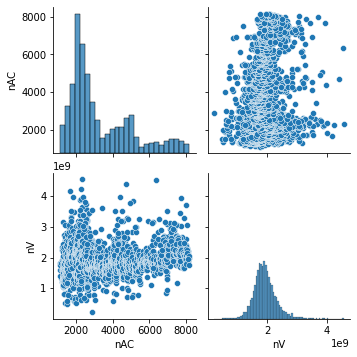

In [11]:
sns.pairplot(nsdq);

In [12]:
df = pd.concat([sp500, nsdq, msft, aapl], axis=1)
df.head()

,sAC,sV,nAC,nV,mAC,mV,aAC,aV
Date,,,,,,,,
2000-01-03,1455.219971,931800000,4131.149902,1510070000,42.115314,53228400,2.665724,133949200
2000-01-04,1399.420044,1009000000,3901.689941,1511840000,40.692646,54119000,2.440975,128094400
2000-01-05,1402.109985,1085500000,3877.540039,1735670000,41.121727,64059600,2.476697,194580400
2000-01-06,1403.449951,1092300000,3727.129883,1598320000,39.744217,54976600,2.262367,191993200
2000-01-07,1441.469971,1225200000,3882.620117,1634930000,40.263588,62013600,2.369532,115183600


In [13]:
from fbprophet import Prophet

# pull only close price and set up dataframe for prophet
aapl_fb = aapl
aapl_fb['ds'] = aapl_fb.index
aapl_fb = aapl_fb.rename(columns={'aAC': 'y'})

In [14]:
aapl_fb.head()

,y,aV,ds
Date,,,
2000-01-03,2.665724,133949200,2000-01-03
2000-01-04,2.440975,128094400,2000-01-04
2000-01-05,2.476697,194580400,2000-01-05
2000-01-06,2.262367,191993200,2000-01-06
2000-01-07,2.369532,115183600,2000-01-07


In [15]:
# fit model without final thirty periods
fbm = Prophet(weekly_seasonality='auto', daily_seasonality=False, seasonality_mode='additive')

fbm.fit(aapl_fb.iloc[:-30,:]);

# create future dataset
future = fbm.make_future_dataframe(periods=30, freq='D')
future.tail()

,ds
4860,2019-04-17
4861,2019-04-18
4862,2019-04-19
4863,2019-04-20
4864,2019-04-21


In [16]:
aapl_fb.iloc[-30,:]
forecast = fbm.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
4860,2019-04-17,193.258873,180.634527,205.896773
4861,2019-04-18,193.290025,181.339801,203.916553
4862,2019-04-19,193.288413,181.380939,205.659757
4863,2019-04-20,193.520526,181.368466,204.795072
4864,2019-04-21,193.605109,180.664280,205.863594


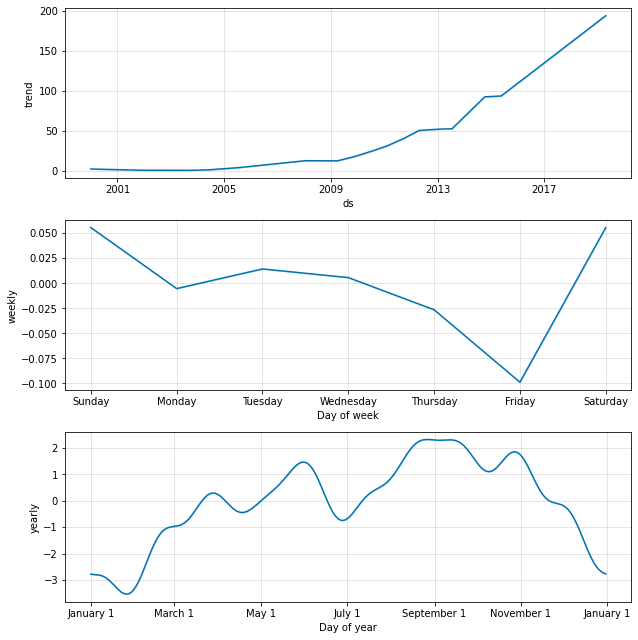

In [17]:
fbm.plot_components(forecast);

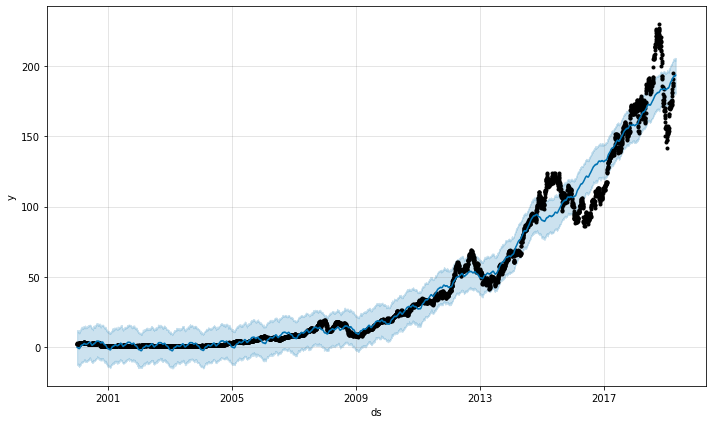

In [18]:
pred_plot = fbm.plot(forecast)

In [19]:
# calculate MAE

diffs = np.absolute(aapl_fb.y[-30:].values - forecast.yhat[-30:].values)

diffs.mean() # this is our metric for comparison

8.223783622551272

In [20]:
df = df.T